In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, SGDRegressor, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score

In [2]:
# 1. Load dataset (California Housing)
data = fetch_california_housing(as_frame=True)
X = data.frame.drop(columns=["MedHouseVal"])
y = data.frame["MedHouseVal"]


In [3]:
# For classification task, create binary target: above median price = 1 else 0
y_class = (y > y.median()).astype(int)


In [4]:
# 2. Train-test split for regression and classification (make sure same indices)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
_, _, y_class_train, y_class_test = train_test_split(X, y_class, random_state=42, test_size=0.2)

In [5]:
# Function to plot learning curves
def plot_learning_curves(estimator, X, y, title, scoring=None):
    train_sizes, train_scores, val_scores = learning_curve(estimator, X, y,
                                                           train_sizes=np.linspace(0.1, 1.0, 5),
                                                           cv=5, scoring=scoring, n_jobs=-1)
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    plt.figure()
    plt.plot(train_sizes, train_mean, "o-", label="Training score")
    plt.plot(train_sizes, val_mean, "o-", label="Validation score")
    plt.title(title)
    plt.xlabel("Training set size")
    plt.ylabel("Score")
    plt.legend()
    plt.grid()
    plt.show()


In [16]:
# Function to plot feature importance (coefficients)
def plot_feature_importance(model, name, feature_names=None):
    if hasattr(model.named_steps[list(model.named_steps.keys())[-1]], 'coef_'):
        coefs = model.named_steps[list(model.named_steps.keys())[-1]].coef_
        # Handle multi-dimensional coef_ for models like LogisticRegression
        if coefs.ndim > 1:
            coefs = coefs[0]  # Take the first row for binary classification
        if feature_names is None:
            feature_names = [f"x{i}" for i in range(len(coefs))]
        plt.figure(figsize=(10, 4))
        plt.bar(np.arange(len(coefs)), coefs)
        plt.title(f"Feature Importance: {name}")
        plt.xlabel("Features")
        plt.ylabel("Coefficient Value")
        plt.xticks(np.arange(len(coefs)), feature_names, rotation=90)
        plt.tight_layout()
        plt.grid(True)
        plt.show()

In [17]:
# Evaluation for regression
def evaluate_regression(model, X_test, y_test):
    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    return rmse, r2

In [18]:
# Evaluation for classification
def evaluate_classification(model, X_test, y_test):
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    return acc, f1

results = []

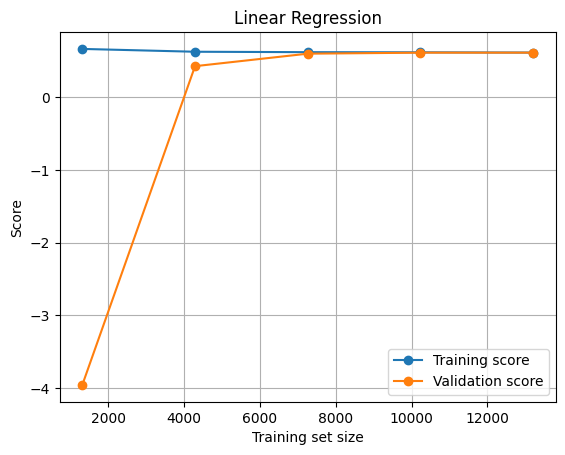

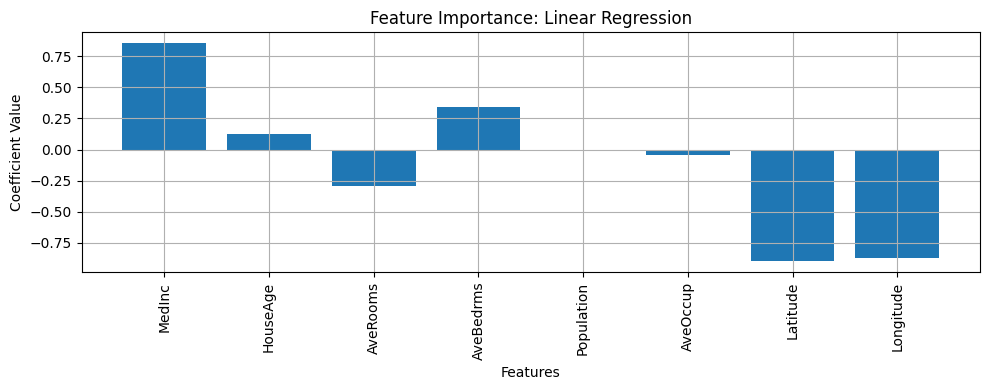

In [19]:
# === Model 1: Linear Regression ===
lin_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("lin_reg", LinearRegression())
])
start = time.time()
lin_reg.fit(X_train, y_train)
train_time_lin = time.time() - start
rmse_lin, r2_lin = evaluate_regression(lin_reg, X_test, y_test)
plot_learning_curves(lin_reg, X_train, y_train, "Linear Regression", scoring='r2')
plot_feature_importance(lin_reg, "Linear Regression", X.columns)
results.append(("Linear Regression", rmse_lin, r2_lin, train_time_lin))

In [20]:
# === Model 2: Ridge Regression with Polynomial Features ===
ridge = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("scaler", StandardScaler()),
    ("ridge", Ridge())
])

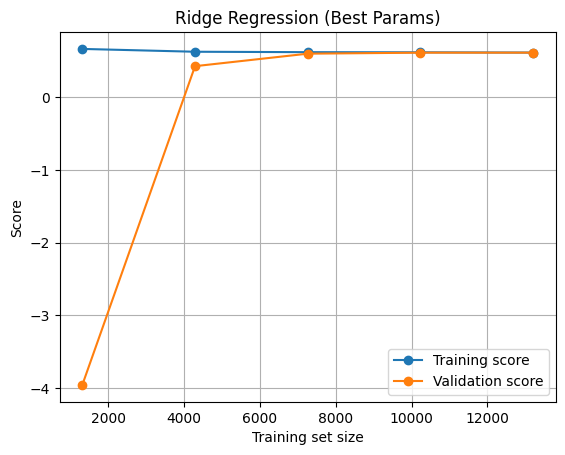

In [21]:
# Hyperparameter tuning GridSearchCV for Ridge alpha and polynomial degree
param_grid_ridge = {
    "poly__degree": [1, 2, 3],
    "ridge__alpha": [0.01, 0.1, 1.0, 10.0]
}
grid_ridge = GridSearchCV(ridge, param_grid_ridge, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
start = time.time()
grid_ridge.fit(X_train, y_train)
train_time_ridge = time.time() - start
best_ridge = grid_ridge.best_estimator_
rmse_ridge, r2_ridge = evaluate_regression(best_ridge, X_test, y_test)
plot_learning_curves(best_ridge, X_train, y_train, "Ridge Regression (Best Params)", scoring='r2')

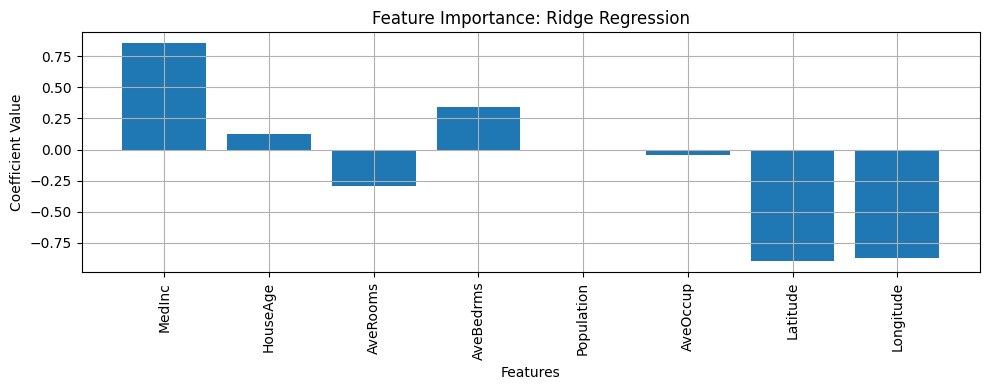

In [22]:
# Get feature names after polynomial expansion for plotting
poly_feature_names_ridge = best_ridge.named_steps['poly'].get_feature_names_out(X.columns)
plot_feature_importance(best_ridge, "Ridge Regression", poly_feature_names_ridge)

results.append(("Ridge Regression", rmse_ridge, r2_ridge, train_time_ridge))

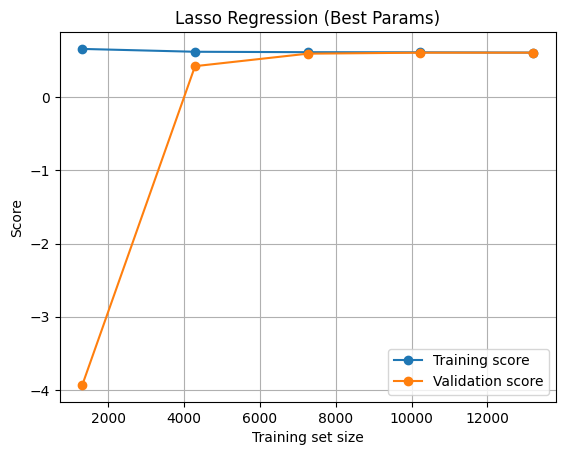

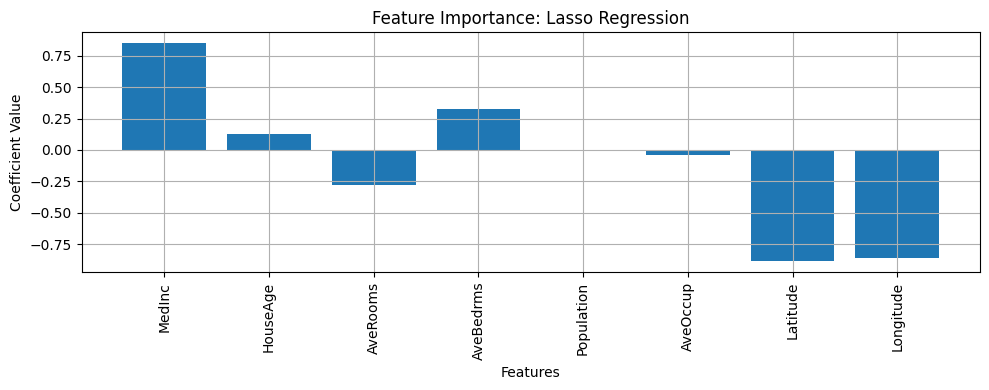

In [23]:
# === Model 3: Lasso Regression with Polynomial Features ===
lasso = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scaler", StandardScaler()),
    ("lasso", Lasso(max_iter=5000))
])

param_grid_lasso = {
    "poly__degree": [1, 2, 3],
    "lasso__alpha": [0.001, 0.01, 0.1, 1.0]
}
grid_lasso = GridSearchCV(lasso, param_grid_lasso, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
start = time.time()
grid_lasso.fit(X_train, y_train)
train_time_lasso = time.time() - start
best_lasso = grid_lasso.best_estimator_
rmse_lasso, r2_lasso = evaluate_regression(best_lasso, X_test, y_test)
plot_learning_curves(best_lasso, X_train, y_train, "Lasso Regression (Best Params)", scoring='r2')

poly_feature_names_lasso = best_lasso.named_steps['poly'].get_feature_names_out(X.columns)
plot_feature_importance(best_lasso, "Lasso Regression", poly_feature_names_lasso)

results.append(("Lasso Regression", rmse_lasso, r2_lasso, train_time_lasso))

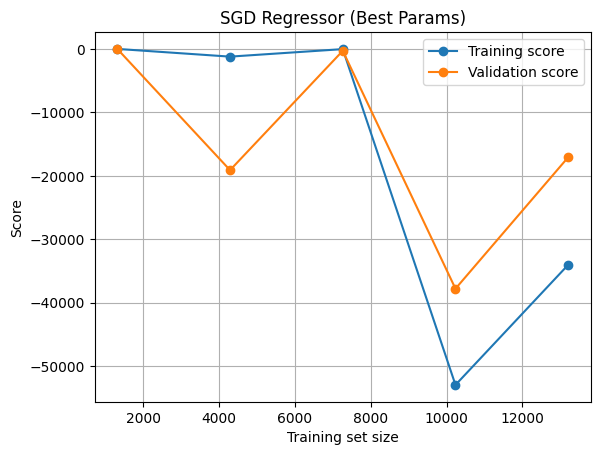

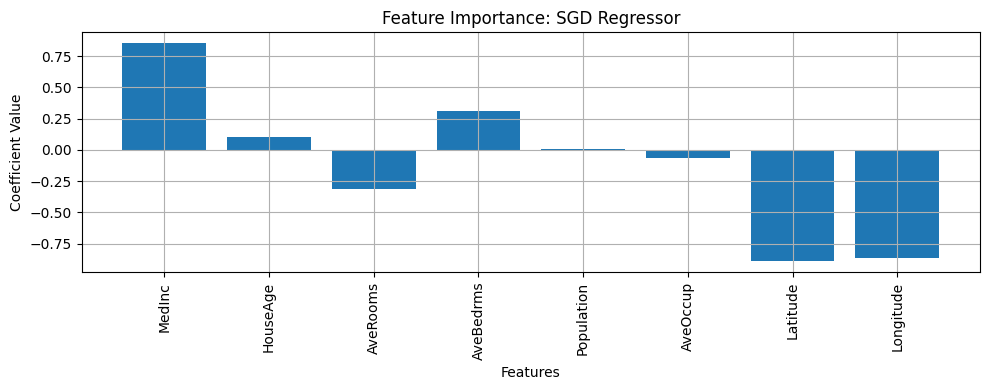

In [24]:
# === Model 4: SGD Regressor ===
sgd_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("sgd_reg", SGDRegressor(max_iter=1000, tol=1e-3))
])
param_grid_sgd_reg = {
    "sgd_reg__alpha": [0.0001, 0.001, 0.01],
    "sgd_reg__learning_rate": ['invscaling', 'adaptive']
}
grid_sgd_reg = GridSearchCV(sgd_reg, param_grid_sgd_reg, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
start = time.time()
grid_sgd_reg.fit(X_train, y_train)
train_time_sgd_reg = time.time() - start
best_sgd_reg = grid_sgd_reg.best_estimator_
rmse_sgd_reg, r2_sgd_reg = evaluate_regression(best_sgd_reg, X_test, y_test)
plot_learning_curves(best_sgd_reg, X_train, y_train, "SGD Regressor (Best Params)", scoring='r2')
plot_feature_importance(best_sgd_reg, "SGD Regressor", X.columns)

results.append(("SGD Regressor", rmse_sgd_reg, r2_sgd_reg, train_time_sgd_reg))

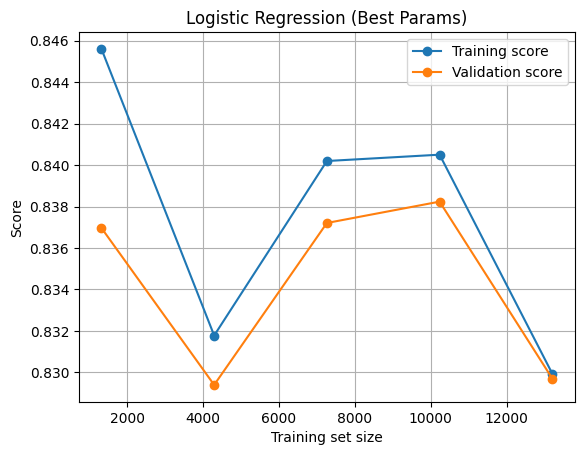

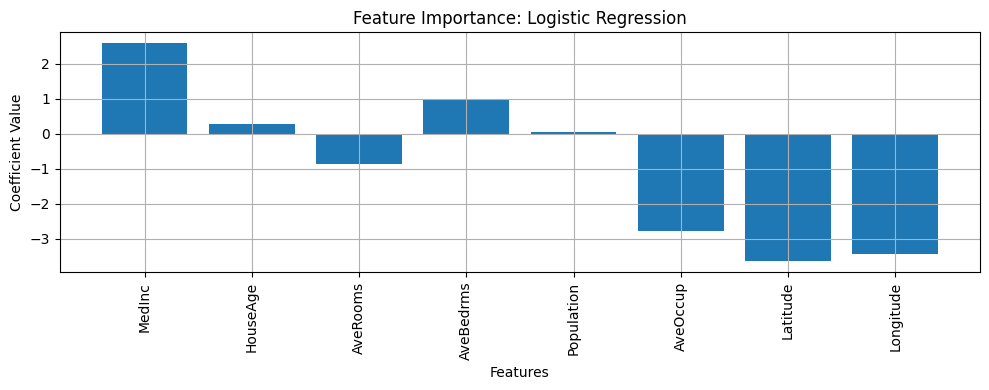

In [27]:
# === Model 5: Logistic Regression (Classification) ===
log_reg = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000))
])

param_grid_logreg = {
    "logreg__C": [0.01, 0.1, 1, 10]
}
grid_logreg = GridSearchCV(log_reg, param_grid_logreg, cv=5, scoring='accuracy', n_jobs=-1)
start = time.time()
grid_logreg.fit(X_train, y_class_train)
train_time_logreg = time.time() - start
best_logreg = grid_logreg.best_estimator_
acc_log, f1_log = evaluate_classification(best_logreg, X_test, y_class_test)
plot_learning_curves(best_logreg, X_train, y_class_train, "Logistic Regression (Best Params)", scoring='accuracy')
plot_feature_importance(best_logreg, "Logistic Regression", X.columns)

results.append(("Logistic Regression", acc_log, f1_log, train_time_logreg))

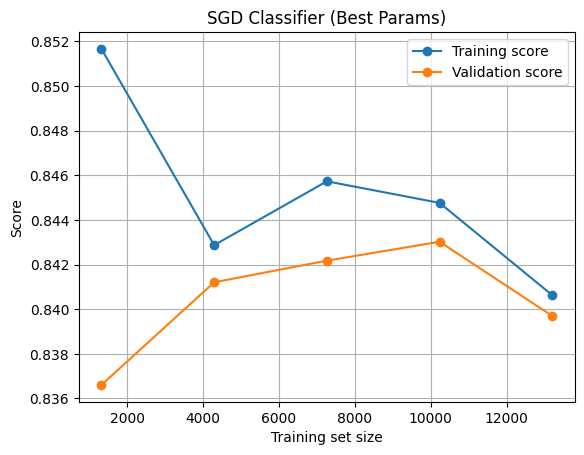

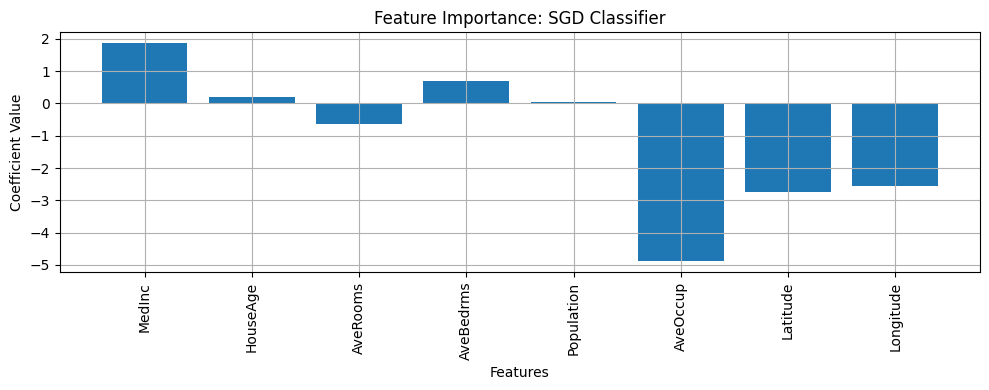

In [30]:
# === Model 6: SGD Classifier (Classification) ===
sgd_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("sgd_clf", SGDClassifier(max_iter=1000, tol=1e-3))
])

param_grid_sgd_clf = {
    "sgd_clf__alpha": [0.0001, 0.001, 0.01],
    "sgd_clf__learning_rate": ['invscaling', 'adaptive'],
    "sgd_clf__eta0": [0.01, 0.05, 0.1] # Add eta0 to the parameter grid
}
grid_sgd_clf = GridSearchCV(sgd_clf, param_grid_sgd_clf, cv=5, scoring='accuracy', n_jobs=-1)
start = time.time()
grid_sgd_clf.fit(X_train, y_class_train)
train_time_sgd_clf = time.time() - start
best_sgd_clf = grid_sgd_clf.best_estimator_
acc_sgd, f1_sgd = evaluate_classification(best_sgd_clf, X_test, y_class_test)
plot_learning_curves(best_sgd_clf, X_train, y_class_train, "SGD Classifier (Best Params)", scoring='accuracy')
plot_feature_importance(best_sgd_clf, "SGD Classifier", X.columns)

results.append(("SGD Classifier", acc_sgd, f1_sgd, train_time_sgd_clf))

In [31]:
# Display results
results_df = pd.DataFrame(results, columns=["Model", "Metric 1", "Metric 2", "Training Time (s)"])

# Determine metric names based on the first model's type (regression or classification)
if results[0][0] in ["Linear Regression", "Ridge Regression", "Lasso Regression", "SGD Regressor"]:
    results_df.columns = ["Model", "RMSE", "R2 Score", "Training Time (s)"]
elif results[0][0] in ["Logistic Regression", "SGD Classifier"]:
     results_df.columns = ["Model", "Accuracy", "F1 Score", "Training Time (s)"]

display(results_df)

,Model,RMSE,R2 Score,Training Time (s)
0,Linear Regression,0.745581,0.575788,0.011719
1,Ridge Regression,0.745581,0.575788,2.999316
2,Lasso Regression,0.744642,0.576856,158.191893
3,SGD Regressor,0.738372,0.583952,1.312347
4,Logistic Regression,0.826308,0.825165,0.783787
5,Logistic Regression,0.826308,0.825165,0.930583
6,SGD Classifier,0.834302,0.832517,4.588991


In [32]:
# === Comparative results table ===
# For regression models: RMSE, R2, Training time
# For classification models: Accuracy, F1-score, Training time

df_results = pd.DataFrame(results, columns=['Model', 'Metric1', 'Metric2', 'Training Time (s)'])

# Rename columns for clarity depending on task
df_results.loc[df_results['Model'].isin(['Logistic Regression', 'SGD Classifier']), ['Metric1', 'Metric2']] = \
    df_results.loc[df_results['Model'].isin(['Logistic Regression', 'SGD Classifier']), ['Metric1', 'Metric2']].astype(float)

df_results.loc[df_results['Model'].isin(['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'SGD Regressor']), ['Metric1', 'Metric2']] = \
    df_results.loc[df_results['Model'].isin(['Linear Regression', 'Ridge Regression', 'Lasso Regression', 'SGD Regressor']), ['Metric1', 'Metric2']].astype(float)

df_results = df_results.rename(columns={
    'Metric1': 'RMSE / Accuracy',
    'Metric2': 'R2 / F1-score'
})

print("\n=== Model Comparison Table ===")
print(df_results)


=== Model Comparison Table ===
                 Model  RMSE / Accuracy  R2 / F1-score  Training Time (s)
0    Linear Regression         0.745581       0.575788           0.011719
1     Ridge Regression         0.745581       0.575788           2.999316
2     Lasso Regression         0.744642       0.576856         158.191893
3        SGD Regressor         0.738372       0.583952           1.312347
4  Logistic Regression         0.826308       0.825165           0.783787
5  Logistic Regression         0.826308       0.825165           0.930583
6       SGD Classifier         0.834302       0.832517           4.588991
